# RAG Example

An example based from HuggingFace where we build a RAG architecture.

Source: https://huggingface.co/learn/cookbook/en/rag_zephyr_langchain


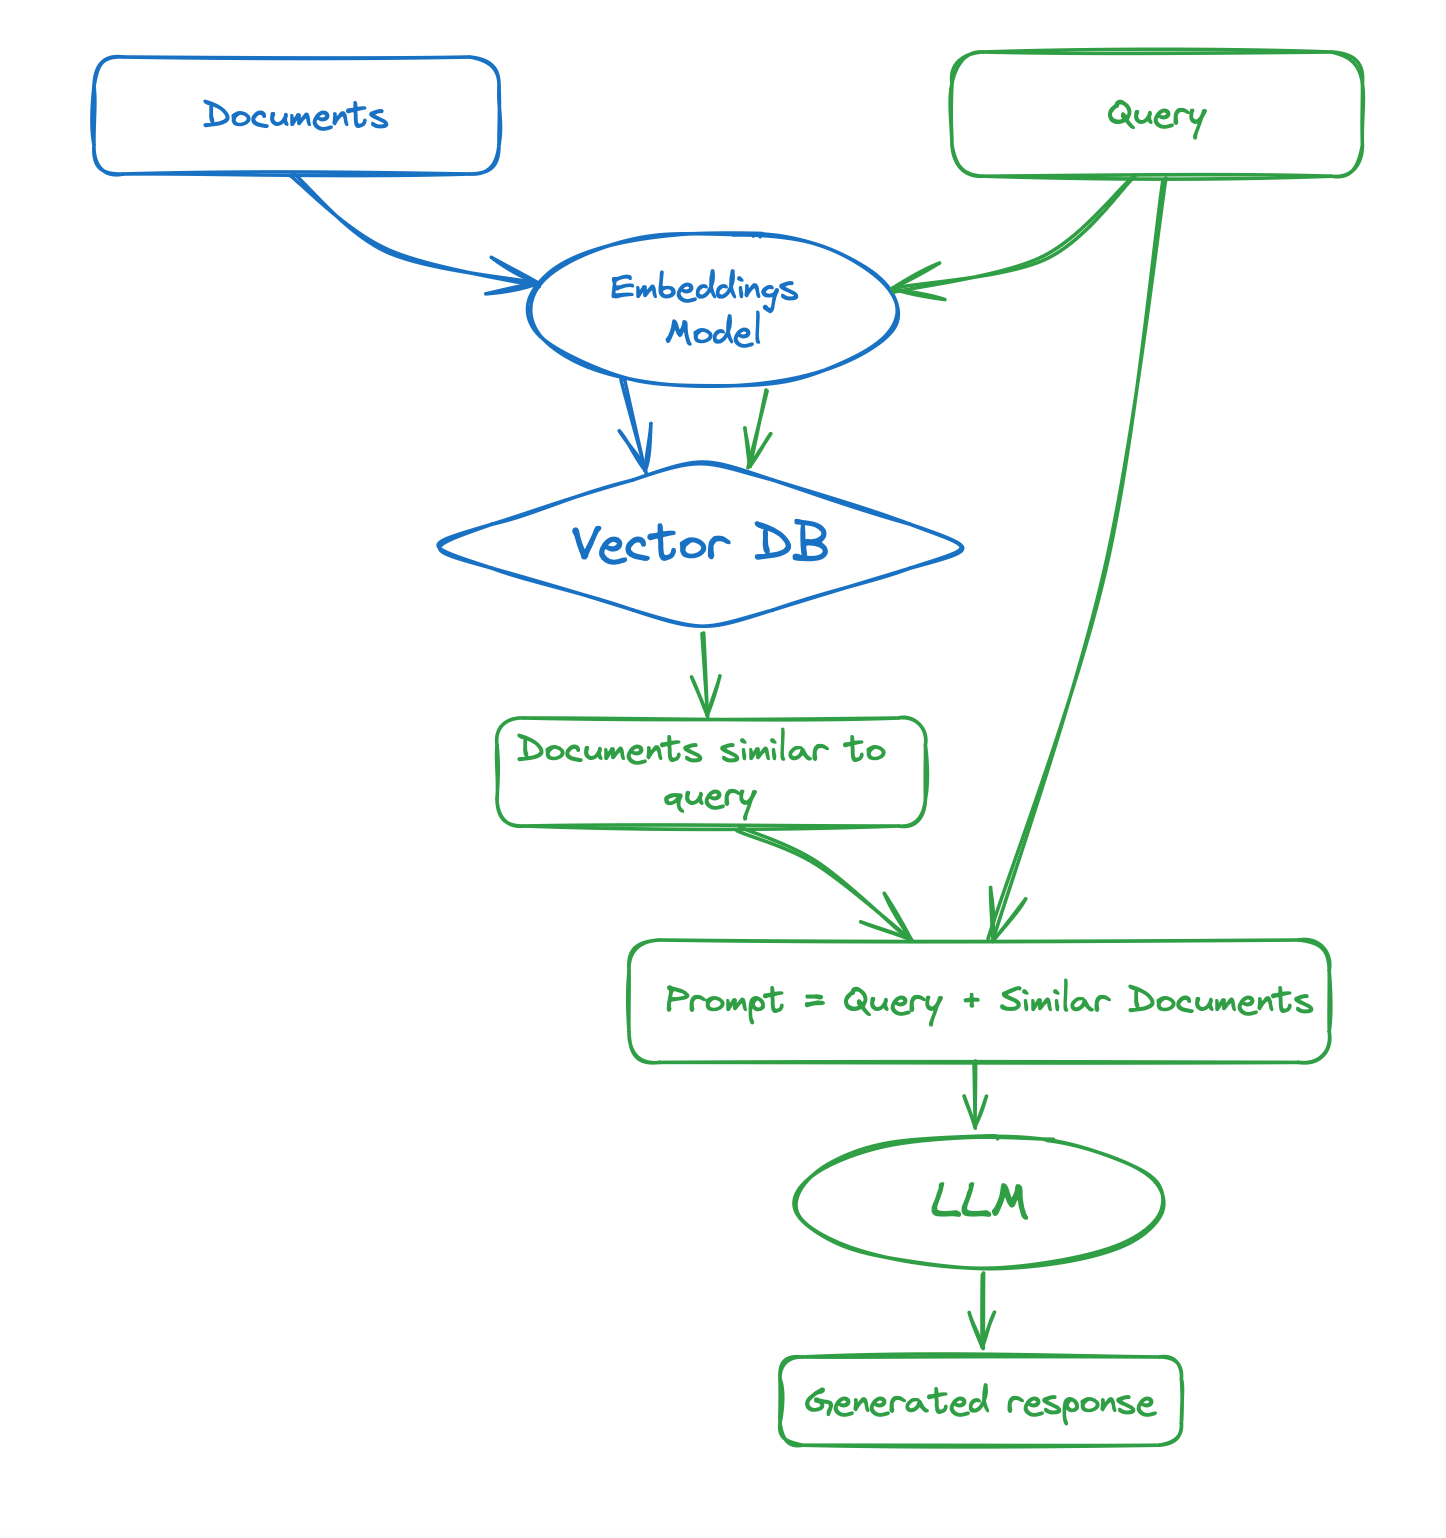

In [1]:
import locale
from IPython.display import clear_output

locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
!pip install -q torch transformers accelerate bitsandbytes transformers sentence-transformers faiss-gpu langchain
clear_output()

## 0. Initial setup

In [3]:
import os
import yaml
from google.colab import drive
from getpass import getpass

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Read YAML file
f_path = "/content/drive/MyDrive/GitHub/python-codebase/machine_learning/private_keys.yml"
with open(f_path, 'r') as stream:
    data_loaded = yaml.safe_load(stream)
os.environ['HUGGINGFACEHUB_API_TOKEN'] = data_loaded['HF_API_KEY']
os.environ['GITHUB_TOKEN'] = data_loaded['GITHUB_TOKEN']

## 1. Load dataset for RAG

* As a reference, we load all of the issues (both open and closed) from PEFT library's repo.

In [5]:
from langchain.document_loaders import GitHubIssuesLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

In [6]:
# Load dataset
loader = GitHubIssuesLoader(
    repo="huggingface/peft",
    access_token=os.environ['GITHUB_TOKEN'],
    include_prs=False,
    state="all"
)
docs = loader.load()
clear_output()

In [7]:
docs[0]

Document(page_content='### Feature request\n\nEETQ: https://github.com/NetEase-FuXi/EETQ\r\n\r\nEETQ quantization is with great performance during inference supported by TGI and LoRAX already, so that if it could be supported by finetuning that would be great for QLoRA training and inference.\n\n### Motivation\n\nAchieve good inference performance for QLoRA-ed model.\n\n### Your contribution\n\nMay be preparing PR, but depends on the complexity.', metadata={'url': 'https://github.com/huggingface/peft/issues/1643', 'title': 'Support EETQ QLoRA', 'creator': 'thincal', 'created_at': '2024-04-12T13:56:02Z', 'comments': 1, 'state': 'open', 'labels': [], 'assignee': None, 'milestone': None, 'locked': False, 'number': 1643, 'is_pull_request': False})

In [9]:
len(docs)

849

In [31]:
# If we want to embed all of the available content, we need to chunk the documents into appropriately sized pieces.
splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=30)
chunked_docs = splitter.split_documents(docs[:30])

In [29]:
for i in range(len(docs)):
  if len(docs[i].page_content)>512:
    print(docs[i].page_content)
    print("="*100)
    print()
    print(chunked_docs[i].page_content)
    break

### System Info

accelerate==0.28.0
diffusers==0.27.0
peft==0.9.0
transformers==4.38.2

Amazon EC2 instance (g5.2xlarge)
Deep Learning OSS Nvidia Driver AMI GPU PyTorch 2.0.1 (Amazon Linux 2)


### Who can help?

@pacman100 @younesbelkada

### Information

- [ ] The official example scripts
- [X] My own modified scripts

### Tasks

- [X] An officially supported task in the `examples` folder
- [ ] My own task or dataset (give details below)

### Reproduction

Problem Setup
---
I am using the `peft` library to run SDXL + LoRA inference. We aim to support thousands of LoRAs. Here is the high-level algorithm that we are using on each query.

At model setup time, we load an SDXL model:
```
t2i_pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16").to("cuda")
```

Then, for each query:

**Step 1**: Load the adapter into GPU, either from disk or CPU.
```
ensure_lora_is_on_gpu(request.adapter)
t2i_pip

## 2. Create the embeddings + retriever

* Create a database with their embeddings
* We use an embeddings model from HuggingFace (https://huggingface.co/spaces/mteb/leaderboard). E.g., BAAI/bge-base-en-v1.5 embeddings model.

In [32]:
embedding_model = "BAAI/bge-base-en-v1.5"
db = FAISS.from_documents(
    chunked_docs,
    HuggingFaceEmbeddings(model_name=embedding_model)
)

In [33]:
# Method for returning (retrieve) the documents given an unstructured query.
retriever = db.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 4}
)

In [34]:
# Save backup DB
f_path_db = "/content/drive/MyDrive/GitHub/python-codebase/machine_learning/generative_ai/faiss_index"
db.save_local(f_path_db)
# new_db = FAISS.load_local("faiss_index", embeddings)
# docs = new_db.similarity_search(query)


## 3. Load LLM

* https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard

In [40]:
!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes
clear_output()

In [35]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from transformers import pipeline
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

In [ ]:
# Load model

#model_name = "mistralai/Mistral-7B-Instruct-v0.2"
model_name = "HuggingFaceH4/zephyr-7b-beta"
#model_name = "google/gemma-7b"
#model_name = "google/flan-ul2"

'''
task = 'text-generation'
dct_llm_params = {
    "max_new_tokens": 128,
    #"top_k": 5,
    "temperature": 0.3,
    #"repetition_penalty": 1.03,
}

llm = HuggingFaceHub(
    repo_id=model_name,
    task=task,
    model_kwargs=dct_llm_params,
)
'''

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    #quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
# Setup the LLM chain
text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    do_sample=True,
    repetition_penalty=1.1,
    return_full_text=True,
    max_new_tokens=400,
)

llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

prompt_template = """
<|system|>
Answer the question based on your knowledge. Use the following context to help:

{context}

</s>
<|user|>
{question}
</s>
<|assistant|>

 """

prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

llm_chain = prompt | llm | StrOutputParser()


In [ ]:
# Combine de LLM chain w/ the retriever
#retriever = db.as_retriever()
rag_chain = {"context": retriever, "question": RunnablePassthrough()} | llm_chain

## 4. Evaluation
* RAG vs no RAG

In [ ]:
# Compare the results
question = "How do you combine multiple adapters?"

In [ ]:
# Answering w/o RAG
llm_chain.invoke({"context": "", "question": question})

In [ ]:
# Answering w/ RAG
rag_chain.invoke(question)

# RAG Example (II)

* References: https://github.com/pinecone-io/examples/blob/master/learn/generation/langchain/handbook/05-langchain-retrieval-augmentation.ipynb

In [7]:
!pip install -qU datasets apache_beam mwparserfromhell langchain pinecone-client==3.1.0 tiktoken==0.5.2 faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.5 MB/s eta 0:00:00


In [3]:
!pip install -e .
!pip install --no-deps multiprocess>=0.70.11

Obtaining file:///content
ERROR: file:///content does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


## 0. Setup

In [5]:
import os
import yaml
from google.colab import drive
from getpass import getpass

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Read YAML file
f_path = "/content/drive/MyDrive/GitHub/python-codebase/machine_learning/private_keys.yml"
with open(f_path, 'r') as stream:
    data_loaded = yaml.safe_load(stream)
os.environ['HUGGINGFACEHUB_API_TOKEN'] = data_loaded['HF_API_KEY']
os.environ['GITHUB_TOKEN'] = data_loaded['GITHUB_TOKEN']

## 1. Build dataset

In [30]:
import tiktoken
import pandas as pd
#from datasets import load_dataset
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document

In [9]:
df_input = pd.read_parquet('/content/drive/MyDrive/GitHub/python-codebase/machine_learning/datasets/train-00040-of-00041.parquet', engine='pyarrow')

In [10]:
df_input.head()

,id,url,title,text
0,67963775,https://en.wikipedia.org/wiki/The%20Angel%20of...,The Angel of 8th Ave.,"""The Angel of 8th Ave."" (stylised in all lower..."
1,67963778,https://en.wikipedia.org/wiki/Hurricane%20Muni...,Hurricane Municipal Airport,"Hurricane Municipal Airport , also known as Ge..."
2,67963783,https://en.wikipedia.org/wiki/Satin%20berrypecker,Satin berrypecker,"The satin berrypecker (Melanocharis citreola),..."
3,67963841,https://en.wikipedia.org/wiki/Cassinia%20compl...,Cassinia complanata,"Cassinia complanata, commonly known as smooth ..."
4,67963851,https://en.wikipedia.org/wiki/Monoporella,Monoporella,Monoporella is a genus of bryozoans belonging ...


In [26]:
len(df_input)

157528

In [13]:
# create the length function
tokenizer = tiktoken.get_encoding('cl100k_base')

def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

In [14]:
# Example: check length
tiktoken_len("hello I am a chunk of text and using the tiktoken_len function "
             "we can find the length of this chunk of text in tokens")

26

In [ ]:
# Build Knowledge Base
#data = load_dataset("wikipedia", "20220301.simple", split='train[:10000]')
#data

In [ ]:
#data[6]

We now aim to chunk these articles into more "concise" chunks to later be embedding and stored in our Pinecone vector database.

In [15]:
# Text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,
    length_function=tiktoken_len,
    separators=["\n\n", "\n", " ", ""]
)

In [17]:
chunks = text_splitter.split_text(df_input['text'].values[9])[:3]
chunks

['Otohydra is a genus of cnidarians belonging to the monotypic family Otohydridae.\n\nSpecies:\n\nOtohydra tremulans \nOtohydra vagans\n\nReferences\n\nActinulida\nHydrozoan genera']

In [19]:
tiktoken_len(chunks[0])

54

In [52]:
list_of_documents = []
for page_content in chunks:
  concat_text = ""
  for text in page_content:
    concat_text = concat_text + ' ' + text
    list_of_documents.append(Document(page_content=concat_text, metadata=dict(page=1)))

## 2. Create vector DB

In [27]:
chunks = [text_splitter.split_text(x) for x in list(df_input['text'].values)[:200]]
chunks[0]

['"The Angel of 8th Ave." (stylised in all lowercase) is a song by Australian alternative rock band Gang of Youths, released on 15 June 2021 as the lead single from their second EP, Total Serene (2021). The track also features on the band\'s third studio album, Angel in Realtime (2022).\n\nFrontman David Le\'aupepe said the song was inspired by "falling in love and finding a new life in a new city together."\n\nAt the 2021 ARIA Music Awards, the song earned a nomination for Best Group.\n\nMusic video\nThe music video was released on 16 June 2021. The video was directed by Joel Barney and filmed in the Angel area of London.\n\nCritical reception\nAl Newstead from Triple J called it a "big, cathartic rock number." Emmy Mack from Music Feeds said, "it\'s made of the same poetic, life-affirming, retro-infused indie rock that fans have grown to know and love from Gang of Youths".\n\nChart performance\nOn 23 June 2021, Australian Recording Industry Association (ARIA) released their mid-week 

In [ ]:
embedding_model = "BAAI/bge-base-en-v1.5"
db = FAISS.from_documents(
    list_of_documents,
    HuggingFaceEmbeddings(model_name=embedding_model)
)

In [ ]:
# Method for returning (retrieve) the documents given an unstructured query.
retriever = db.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 4}
)

In [ ]:
# Querying
query = "What's the Angel of 8th Ave.?"
docs = db.similarity_search(query)
print(docs[0].page_content)

In [ ]:
# Retriever
retriever = db.as_retriever()
docs = retriever.invoke(query)
print(docs[0].page_content)